In [ ]:
!pip install -q numpy==1.23.5 pandas scipy==1.11 requests tqdm \
               cornac==1.15.4

In [ ]:
"""End‑to‑end recommender‑system pipeline.

Changes vs. original
--------------------
1. **Random/temporal split selector** – controlled by ``CFG.split_mode`` and
   ``CFG.train_frac``.
2. **Text/autoencoder tweaks**       – richer CDL search space, larger vocab
   and more iterations (see Block 2).
3. **Robust bucket metrics**         – guarded divisions by zero (Block 6).
4. **Minor hygiene**                 – defragmented DataFrame inserts, clearer
   doc‑strings, sklearn dependency.

The global structure and public function signatures are preserved so that
existing notebooks can simply replace the file and re‑run.
"""

# ---------- mandatory installs ---------------------------------------------
!pip install -q numpy==1.23.5 pandas scipy==1.11 requests tqdm \
               cornac==1.15.4 scikit-learn==1.4.2

from __future__ import annotations
import os, logging, requests, shutil, random, json, gzip
from dataclasses import dataclass
from functools import reduce
from typing import List, Dict, Tuple

import numpy as np, pandas as pd
from pandas.errors import EmptyDataError

# ─── 1 · CONFIG ──────────────────────────────────────────────────────────────
@dataclass
class CFG:
    """Global hyper‑parameters and runtime switches."""
    ds_index   : int   = 21      # 34 → ML‑100K, 35 → ML‑1M, 0‑33 → Amazon
    k_core     : int   = 4
    frac       : float = 1.0
    # ---------------------------------------------------- model families ----
    run_cf     : bool  = True
    run_text   : bool  = True
    run_dense  : bool  = False
    # ------------------------------------------------------ HPO presets ----
    hpo_preset     = "small"     # { "proto", "small", "large" }
    n_hpo_points   : int  = 8
    parallel_hpo   : bool = True
    enable_critic  : bool = False
    # -------------------------------------------------------- random seed ---
    seed : int = 42
    # -------------------------------------------------------- data split ----
    split_mode : str  = "random"   # { "temporal", "random" }
    train_frac : float = 0.8          # fraction that goes to *train*
    # -------------------------------------------------------- text params ---
    max_vocab  : int   = 20000        # TextModality vocabulary size
    text_columns = [
        "meta_only", "all_reviews_text", "meta_human",
        "s_synth_dense", "s_synth_aspect",
        "m_synth_dense", "m_synth_aspect",
        "l_synth_dense", "l_synth_aspect",
    ]

RAND = random.Random(CFG.seed)
np.random.seed(CFG.seed)
logging.basicConfig(level=logging.INFO, format="%(levelname)s  %(message)s")

##############################################################################
#  ── GLOBAL SMALL PATCH ─────────────────────────────────────────────────────
##############################################################################
CUTS         = [5, 10, 50]        # evaluation cut‑offs for accuracy metrics
TOPN_FOR_REC = max(CUTS)          # we recommend this many items, then slice


# 2 · DATASET NAMES (unchanged) ---------------------------------------------
AMAZON_LIST = [
    "All_Beauty","Amazon_Fashion","Appliances","Arts_Crafts_and_Sewing","Automotive",
    "Baby_Products","Beauty_and_Personal_Care","Books","CDs_and_Vinyl",
    "Cell_Phones_and_Accessories","Clothing_Shoes_and_Jewelry","Digital_Music",
    "Electronics","Gift_Cards","Grocery_and_Gourmet_Food","Handmade_Products",
    "Health_and_Household","Health_and_Personal_Care","Home_and_Kitchen",
    "Industrial_and_Scientific","Kindle_Store","Magazine_Subscriptions","Movies_and_TV",
    "Musical_Instruments","Office_Products","Patio_Lawn_and_Garden","Pet_Supplies",
    "Software","Sports_and_Outdoors","Subscription_Boxes","Tools_and_Home_Improvement",
    "Toys_and_Games","Video_Games",
]

# helper returns the base slug for downloads ---------------------------------
def _base_name(i:int)->str:
    if i==34: return "movielens100k"
    if i==35: return "movielens1m"
    return AMAZON_LIST[i]

BASE_NAME   = _base_name(CFG.ds_index)
REMOTE_PREF = f"{BASE_NAME}_k{CFG.k_core}"
DS_SLUG     = BASE_NAME
BASE_URL    = ("https://raw.githubusercontent.com/"
               "yasdel/Text_for_CF_and_RAG_RecSys/main/artifacts")
DATA_DIR    = "data_dl"; os.makedirs(DATA_DIR, exist_ok=True)


# ─── 3 · GENERIC HELPERS ─────────────────────────────────────────────────────
def _dl(url:str, dest:str):
    if os.path.exists(dest): return
    logging.info("📥 %s", os.path.basename(dest))
    with requests.get(url, stream=True, timeout=30) as r:
        if r.status_code != 200:
            raise FileNotFoundError(f"{url} → {r.status_code}")
        with open(dest, "wb") as f: shutil.copyfileobj(r.raw, f)

def _is_gzip(path:str)->bool:
    with open(path,"rb") as fh: return fh.read(2)==b"\x1f\x8b"

def _read_csv(path:str)->pd.DataFrame:
    try:
        if _is_gzip(path):
            with gzip.open(path,"rt") as fh: return pd.read_csv(fh)
        return pd.read_csv(path)
    except EmptyDataError:
        logging.warning("⚠️  %s is empty -> returning empty DF", path)
        return pd.DataFrame()

def _read_json(path:str)->dict:
    if _is_gzip(path):
        with gzip.open(path,"rt") as fh: return json.load(fh)
    return json.load(open(path))

def _after_variants(suf:str)->List[str]:
    """
    Given 'quality_metrics.csv.gz' return
        ['quality_metrics_afterCritic.csv.gz', 'quality_metrics_afterCritic.csv']
    preserving single/double extension rules.
    """
    if suf.endswith(".csv.gz"):
        core = suf[:-7]            # drop '.csv.gz'
        return [f"{core}_afterCritic.csv.gz", f"{core}_afterCritic.csv"]
    if suf.endswith(".csv"):
        core = suf[:-4]
        return [f"{core}_afterCritic.csv"]
    return [f"{suf}_afterCritic"]  # fallback

def _looks_empty(path:str)->bool:
    fh = gzip.open(path,'rb') if path.endswith(".gz") else open(path,'rb')
    with fh:
        for _ in range(4):
            if b',' in fh.readline(): return False
    return True

def _artifact_path(cands:List[str])->str:
    """
    Search order: for each candidate X try the _afterCritic variants first,
    then the original X.
    """
    for suf in cands:
        for variant in _after_variants(suf)+[suf]:
            fn   = f"{REMOTE_PREF}_{variant}"
            url  = f"{BASE_URL}/{fn}"
            dest = os.path.join(DATA_DIR, fn)
            try:
                _dl(url, dest)
                if os.path.getsize(dest)<512 or _looks_empty(dest): continue
                logging.info("✓ using %s", dest)
                return dest
            except FileNotFoundError:
                continue
    raise FileNotFoundError(f"{cands} not found for base={REMOTE_PREF}")

def _canon_ids(df:pd.DataFrame)->pd.DataFrame:
    return df.rename(columns={c:"userId" for c in df.columns if c.lower() in ("userid","user_id")}
                            |{c:"itemId" for c in df.columns if c.lower() in ("itemid","item_id")})

# ─── 4 · LOADERS ─────────────────────────────────────────────────────────────
def load_interactions()->pd.DataFrame:
    df=_canon_ids(_read_csv(_artifact_path(["interactions.csv.gz","interactions.csv"])))
    if CFG.k_core>0:
        changed=True
        while changed:
            before=len(df)
            vc=df.userId.value_counts(); df=df[df.userId.isin(vc[vc>=CFG.k_core].index)]
            vc=df.itemId.value_counts(); df=df[df.itemId.isin(vc[vc>=CFG.k_core].index)]
            changed=len(df)<before
    if 0<CFG.frac<1:
        df=df.sample(frac=CFG.frac,random_state=CFG.seed)
    return df.reset_index(drop=True)

def load_side()    ->pd.DataFrame: return _read_csv(_artifact_path(["side_all.csv.gz","side_all.csv"]))
def load_manifest()->dict:         return _read_json(_artifact_path(["manifest.json.gz","manifest.json"]))

def load_metrics() -> pd.DataFrame:
    try:
        return _read_csv(_artifact_path(["quality_metrics.csv.gz","quality_metrics.csv"]))
    except FileNotFoundError:
        logging.warning("⚠️  metrics not found – returning empty DF")
        return pd.DataFrame()

# ─── add directly inside Block-3, right after `metrics = critic(side_all)` ───
# ─── STRICT critic filter ────────────────────────────────────────────────
def _apply_critic_drop(df: pd.DataFrame) -> tuple[pd.DataFrame, int]:
    """
    Remove every item for which *any* length bucket is flagged *_critic_bad*.
    Returns (filtered_df, n_dropped).
    """
    # one Boolean per row: did this item fail in s OR m OR l ?
    bad_any = df[[f"{lab}_critic_bad" for lab in ("s", "m", "l")]].any(axis=1)
    n_bad   = int(bad_any.sum())
    return df.loc[~bad_any].reset_index(drop=True), n_bad

def download_archive()->str:
    fn=f"{REMOTE_PREF}.zip"
    try:
        _dl(f"{BASE_URL}/{fn}", os.path.join(DATA_DIR, fn)); return os.path.join(DATA_DIR, fn)
    except FileNotFoundError:
        return "(archive missing)"

# ─── 5 · OPTIONAL EMBEDDINGS (unchanged placeholder) ─────────────────────────
def load_embeddings()->pd.DataFrame: ...

def ui_stats(df: pd.DataFrame, label: str):
    """Print a one-liner with basic dataset statistics."""
    u = df["userId"].nunique()
    i = df["itemId"].nunique()
    n = len(df)
    print(f"\n{'=' * 50}")
    print(f"📌 [{label}] Dataset Stats:")
    print(f"{'-' * 50}")
    print(f"• Users           : {u:,}")
    print(f"• Items           : {i:,}")
    print(f"• Ratings         : {n:,}")
    print(f"• Avg ratings/user: {n / u if u else 0:.2f}")
    print(f"• Avg ratings/item: {n / i if i else 0:.2f}")
    print(f"• Sparsity        : {n / (u * i) if u * i else 0:.6f}")
    print(f"{'=' * 50}\n")

# ─── 6 · SMOKE-TEST ──────────────────────────────────────────────────────────
if __name__=="__main__":
    inter=load_interactions();
    side_all=load_side();
    # ------------------------------------------------------------------
    metrics=load_metrics();

    # 2) drop bad items and report
    side_after, n_drop = side_all, 0
    if CFG.enable_critic and not metrics.empty:
        side_after, n_drop = _apply_critic_drop(side_all)
        share = n_drop / len(side_all) * 100
        print(f"⚠️  Critic removed {n_drop:,} items ({share:.2f} %)")

    mani=load_manifest()
    zip_path=download_archive()
    print(f"\n✔ {BASE_NAME}  (k={CFG.k_core})")
    print("  interactions :", inter.shape)
    print("  side_all     :", side_all.shape)
    print("  metrics      :", metrics.shape)
    print("  manifest keys:", list(mani.keys()))
    print("  archive      :", zip_path)
    display(inter.head())
    display(side_all.head())
    display(metrics.head())

    ui_stats(inter, f"interactions_{BASE_NAME}")



✔ Magazine_Subscriptions  (k=4)
  interactions : (2145, 5)
  side_all     : (185, 23)
  metrics      : (2220, 5)
  manifest keys: ['review_per_item', 'config', 'sampling']
  archive      : data_dl/Magazine_Subscriptions_k4.zip


,userId,itemId,rating,timestamp,text
0,36,50,5,2018-05-20 15:39:36.794,I have several magazines that I consult for my...
1,36,18,2,2012-05-06 14:48:55.000,Kids like to read magazines and books as long ...
2,36,53,4,2011-12-24 03:59:21.000,Texas Monthly Magazine is a magazine about a s...
3,36,55,4,2010-08-27 16:03:00.000,Popular Mechanics is a magazine dedicated to m...
4,36,59,4,2009-12-12 04:11:42.000,Popular Science is a magazine I have been read...


,itemId,title,features,description,all_reviews_text,n_reviews,meta_only,meta_human,s_synth_dense,s_synth_aspect,...,m_synth_aspect,m_combo_dense,m_combo_aspect,l_synth_dense,l_synth_aspect,l_combo_dense,l_combo_aspect,s_critic_bad,m_critic_bad,l_critic_bad
0,354,Veranda Print Magazine,[],[],VERANDA reigns along with the other three most...,10,Veranda Print Magazine,Veranda Print Magazine VERANDA reigns along...,Transform your outdoor space with Veranda maga...,- **Feature**: Home design inspiration and ide...,...,- **Feature**: Home design inspiration and tip...,Veranda Print Magazine VERANDA reigns along...,Veranda Print Magazine VERANDA reigns along...,Discover the ultimate guide to luxurious outdo...,- **Feature**: Home design inspiration and ide...,Veranda Print Magazine VERANDA reigns along...,Veranda Print Magazine VERANDA reigns along...,False,False,False
1,84,Interview Magazine Print Magazine,[],[],Interview is definitely a different type of ma...,10,Interview Magazine Print Magazine,Interview Magazine Print Magazine Interview...,"Discover the latest in fashion, art, and cultu...",- **Feature**: Glossy pages with high-quality ...,...,- **Feature**: Exclusive interviews with celeb...,Interview Magazine Print Magazine Interview...,Interview Magazine Print Magazine Interview...,"Discover the iconic Interview Magazine, a time...",- **Feature**: Glossy pages for high-quality i...,Interview Magazine Print Magazine Interview...,Interview Magazine Print Magazine Interview...,False,False,False
2,226,Shape Print Magazine,[],['Shape magazine is the authority for women wh...,Good recipes. Good workouts [SEP] All Ads<br /...,10,Shape Print Magazine\nShape magazine is the...,Shape Print Magazine\nShape magazine is the...,Shape magazine is the ultimate guide for women...,- **Feature**: Personalized workout guides\n- ...,...,- **Feature**: Personalized workout guides\n- ...,Shape Print Magazine\nShape magazine is the...,Shape Print Magazine\nShape magazine is the...,Shape magazine is the ultimate guide for women...,- **Feature**: Personalized workout guides\n- ...,Shape Print Magazine\nShape magazine is the...,Shape Print Magazine\nShape magazine is the...,False,False,False
3,262,All You Print Magazine,[],"['Product Description', 'All You -- Enjoy Life...",enjoy all the recipes [SEP] stop auto billing!...,10,All You Print Magazine\nProduct Description...,All You Print Magazine\nProduct Description...,Discover a treasure trove of money-saving tips...,"- **Feature**: Coupons, money-saving tips, aff...",...,"- **Feature**: Coupons, money-saving tips, aff...",All You Print Magazine\nProduct Description...,All You Print Magazine\nProduct Description...,"Discover a world of savings, inspiration, and ...","- **Feature**: Coupons, money-saving tips, aff...",All You Print Magazine\nProduct Description...,All You Print Magazine\nProduct Description...,False,False,False
4,348,InStyle Print Magazine,[],"['Product Description', ""InStyle celebrates th...",good price when on sale. Its for my wife. [SEP...,10,InStyle Print Magazine\nProduct Description...,InStyle Print Magazine\nProduct Description...,InStyle magazine is the ultimate guide for the...,- **Feature**: Personal style choices of fasci...,...,- **Feature**: Reveals personal style choices ...,InStyle Print Magazine\nProduct Description...,InStyle Print Magazine\nProduct Description...,InStyle magazine is the ultimate guide for the...,- **Feature**: Personal style choices of fasci...,InStyle Print Magazine\nProduct Description...,InStyle Print Magazine\nProduct Description...,False,False,False


,itemId,col,perplexity,toxicity,sentiment
0,354,s_synth_dense,52.810757,0.000945,0.8720
1,354,s_synth_aspect,86.394562,0.000635,0.7506
2,354,s_combo_dense,58.976208,0.000775,0.9969
3,354,s_combo_aspect,61.550224,0.000775,0.9965
4,354,m_synth_dense,34.570194,0.000597,0.9890



📌 [interactions_Magazine_Subscriptions] Dataset Stats:
--------------------------------------------------
• Users           : 416
• Items           : 185
• Ratings         : 2,145
• Avg ratings/user: 5.16
• Avg ratings/item: 11.59
• Sparsity        : 0.027872



In [ ]:
side_all.columns

Index(['itemId', 'title', 'features', 'description', 'all_reviews_text',
       'n_reviews', 'meta_only', 'meta_human', 's_synth_dense',
       's_synth_aspect', 's_combo_dense', 's_combo_aspect', 'm_synth_dense',
       'm_synth_aspect', 'm_combo_dense', 'm_combo_aspect', 'l_synth_dense',
       'l_synth_aspect', 'l_combo_dense', 'l_combo_aspect', 's_critic_bad',
       'm_critic_bad', 'l_critic_bad'],
      dtype='object')

In [ ]:
##############################################################################
#  BLOCK 1 — Classical CF models (MF / BPR / VAECF) with 3 HPO presets
##############################################################################
"""
• CFG.hpo_preset ∈ {"proto", "small", "large"}  (default: "small")
• Preset changes both the grid size *and* the training iterations.
• Interface unchanged:  cf_hpo(train_df) → (results_df, model_dict)
"""
import itertools, concurrent.futures, logging
from typing import Dict, Tuple

import numpy as np, pandas as pd
# ▸ NumPy < 1.25 compatibility for Cornac
if not hasattr(np, "dtypes"):          # <-- add this small guard
    np.dtypes = np.dtype


import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import MF, BPR, VAECF
from cornac.metrics import Recall, NDCG
from cornac.data import Dataset

setattr(CFG, "hpo_preset", getattr(CFG, "hpo_preset", "small"))
assert CFG.hpo_preset in {"proto", "small", "large"}

# ---------- helpers ----------------------------------------------------------
def _grid(base_cfg, iters_key, iters_val):
    g = base_cfg.copy()
    g[iters_key] = iters_val
    return g

def _base_grids():
    return {
        "MF":    [{"k": k, "learning_rate": lr}
                  for k, lr in itertools.product([32, 64, 128], [1e-2, 5e-3])],
        "BPR":   [{"k": k, "learning_rate": lr}
                  for k, lr in itertools.product([32, 64, 128], [1e-2, 5e-3])],
        "VAECF": [{"k": k, "learning_rate": lr}
                  for k, lr in itertools.product([32, 64, 128], [1e-3, 5e-4])],
    }

_PRESET_META = {
    #  n_cfg , MFiter, BPRiter, VAEiter
    "proto": (1,  15,  25, 10),
    "small": (4,  30,  50, 20),
    "large": (20, 50, 100, 30),
}

def _grid_for(tag):
    base   = _base_grids()[tag]
    n_cfg, mf_it, bpr_it, vae_it = _PRESET_META[CFG.hpo_preset]
    rng    = np.random.default_rng(CFG.seed)
    base   = base if n_cfg >= len(base) else list(rng.choice(base, n_cfg, replace=False))
    iters  = {"MF": mf_it, "BPR": bpr_it, "VAECF": vae_it}[tag]
    key    = "n_epochs" if tag == "VAECF" else "max_iter"
    return [_grid(b, key, iters) for b in base]

def _valid(cls, prm):                # drops keys the model does not accept
    ok = cls.__init__.__code__.co_varnames
    return {k: v for k, v in prm.items() if k in ok}

def cf_hpo(train_df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, cornac.models.Recommender]]:
    logging.info("▶️  CF preset = %s  |  ratings = %d", CFG.hpo_preset.upper(), len(train_df))

    fb    = train_df[["userId", "itemId", "rating"]].values.tolist()
    split = RatioSplit(fb, test_size=0.1, val_size=0.1, seed=CFG.seed, verbose=False)

    search_space = {"MF": MF, "BPR": BPR, "VAECF": VAECF}
    results, models = [], {}

    for tag, Cls in search_space.items():
        grid = _grid_for(tag)
        logging.info("   • %s  configs=%d", tag, len(grid))

        def _score(params):
            rec = Cls(seed=CFG.seed, **_valid(Cls, params))
            exp = cornac.Experiment(split, [rec], metrics=[Recall(10), NDCG(10)], verbose=False)
            exp.run()
            m   = exp.val_result[0].metric_avg_results
            return 0.5*(m["Recall@10"]+m["NDCG@10"]), params

        if len(grid) == 1:
            best_s, best_p = _score(grid[0])
        else:
            with concurrent.futures.ThreadPoolExecutor(
                    max_workers=None if CFG.parallel_hpo else 1) as ex:
                scored = list(ex.map(_score, grid))
            best_s, best_p = max(scored, key=lambda t: t[0])

        logging.info("     ↳ best %.4f  %s", best_s, best_p)

        full_ds = Dataset.from_uir(fb)
        best    = Cls(seed=CFG.seed, **best_p); best.fit(full_ds)
        models[tag] = best
        results.append({"model": tag, **best_p, "Recall_val": best_s})

    return pd.DataFrame(results), models


In [ ]:
##############################################################################
#  BLOCK 2 — Text-aware recommenders (CTR / CDL / HFT / ConvMF / DeepCoNN)
##############################################################################
"""
Richer search space for CDL, plus ConvMF **and** DeepCoNN baselines.
Public function signatures stay unchanged.
"""
from itertools import product
import logging, itertools
from typing import Tuple, Dict

from cornac.data import TextModality, Dataset
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, NDCG
from cornac.models import (
    CTR, CDL, HFT,
    ConvMF         # dual-CNN on user + item review text
)

_TXT_META = {
    #  n_cfg  CTR-ep  CDL-ep         (HFT max / grad)
    "proto": (1,  25,  50,           (5 ,  5)),
    "small": (4,  50, 100,           (10, 10)),
    "large": (12, 100, 200,          (20, 20)),
}

# ---------------------------------------------------------------------------
#   1 · grid helpers
# ---------------------------------------------------------------------------

# ─── Block 2 · Text-aware recommenders ──────────────────────────────────────
def _ctr_grid():
    """
    Extended grid: now also sweeps lambda_v (text coupling) and lambda_u
    to make sure CTR really uses the text signal.
    """
    n_cfg, ctr_it, *_ = _TXT_META[CFG.hpo_preset]
    rng = np.random.default_rng(CFG.seed)

    base = [{'k': k,
             'lambda_v': lv,          # ↑ stronger ⇒ text matters more
             'lambda_u': lu,          # ↑ weaker reg. on users
             'a': 1, 'b': 0.01}       # leave confidence at defaults
            for k in [32, 64, 128]
            for lv in [1, 10, 50, 100]
            for lu in [0.01, 0.1]]

    rng.shuffle(base)                 # random-pick a manageable subset
    base = base[:max(n_cfg, 8)]

    for g in base:
        g['max_iter'] = ctr_it
    return base

def _cdl_grid(vocab_size):
    n_cfg, _, cdl_it, _ = _TXT_META[CFG.hpo_preset]
    ks     = [64, 128, 256, 512]
    lrs    = [1e-3, 5e-4, 1e-4]
    aes    = [[300], [512, 256]]
    lmbdas = [(1., 1e-2), (1., 1e-3)]           # (λₙ, λᵥ)

    base = [{"k": k, "learning_rate": lr,
             "autoencoder_structure": ae,
             "lambda_n": ln, "lambda_v": lv}
            for k, lr, ae, (ln, lv) in product(ks, lrs, aes, lmbdas)]

    rng  = np.random.default_rng(CFG.seed)
    base = base if n_cfg >= len(base) else list(rng.choice(base, n_cfg, replace=False))
    for g in base:
        g.update(max_iter=cdl_it, rho=0.9, beta=0.1, batch_size=256)
    return base

def _hft_grid(vocab_size):
    n_cfg, _, _, (hft_it, hft_grad) = _TXT_META[CFG.hpo_preset]
    rng  = np.random.default_rng(CFG.seed)
    base = [{"k": k} for k in [16, 32, 64, 128, 256]]
    base = base if n_cfg >= len(base) else list(rng.choice(base, n_cfg, replace=False))
    for g in base:
        g.update(max_iter=hft_it, grad_iter=hft_grad, vocab_size=vocab_size)
    return base

def _convmf_grid(vocab_size, doc_len):
    n_cfg, *_ = _TXT_META[CFG.hpo_preset]
    ks        = [50, 100, 200]
    # much stronger text coupling (paper & Cornac default is 100)
    lam_v     = [25, 50, 100]
    lam_u     = [0.01, 0.1]
    base = [{"k": k,
             "lambda_u": lu,
             "lambda_v": lv,
             "n_epochs": 80,          # ⇐ was 30
             "doc_len": min(doc_len, 400),   # cap long docs to keep GPU mem in check
             "vocab_size": vocab_size}
            for k in ks for lu in lam_u for lv in lam_v]
    rng = np.random.default_rng(CFG.seed)
    return base if n_cfg >= len(base) else list(rng.choice(base, n_cfg, replace=False))


def _valid(cls, prm):
    ok = cls.__init__.__code__.co_varnames
    return {k: v for k, v in prm.items() if k in ok}

# ---------------------------------------------------------------------------
#   2 · single-column HPO
# ---------------------------------------------------------------------------

def text_hpo_one(txt_col: str,
                 train_df, side_df
                 ) -> Tuple[pd.DataFrame, Dict[str, "cornac.models.Recommender"]]:
    """Grid-search over five text-aware models for one side-information column."""
    if txt_col not in side_df.columns:
        logging.warning("❌ Column “%s” missing – skipping", txt_col)
        return pd.DataFrame(), {}

    logging.info("▶️  Text preset %s | column %s", CFG.hpo_preset.upper(), txt_col)

    # ------------------------------------------------------------------ data
    side_df  = side_df.dropna(subset=[txt_col]).copy()
    train_df = train_df[train_df.itemId.isin(side_df.itemId)]
    tm = TextModality(corpus=side_df[txt_col].tolist(),
                      ids=side_df.itemId.tolist(),
                      max_vocab=CFG.max_vocab).build()
    vsize   = tm.vocab.size - 4
    doc_len = max(len(t.split()) for t in side_df[txt_col])
    fb      = train_df[["userId", "itemId", "rating"]].values.tolist()

    split = RatioSplit(fb, test_size=0.1, val_size=0.1,
                       item_text=tm, seed=CFG.seed, verbose=False)
    split.train_set.item_text = tm
    split.val_set.item_text   = tm

    # ------------------------------------------------------------- search cfg
    search = {
        "CTR":      _ctr_grid(),
        "CDL":      _cdl_grid(vsize),
        "HFT":      _hft_grid(vsize),
        "ConvMF":   _convmf_grid(vsize, doc_len)    }

    res_rows, models = [], {}
    cls_map = {"CTR": CTR, "CDL": CDL, "HFT": HFT,
               "ConvMF": ConvMF}

    for tag, grid in search.items():
        Cls = cls_map[tag]
        logging.info("   • %-7s (%s) configs=%d", tag, txt_col, len(grid))

        def _score(params):
            rec = Cls(seed=CFG.seed, **_valid(Cls, params))
            if isinstance(rec, CDL):   # keep HPO tidy
                rec.vocab_size = vsize
            exp = cornac.Experiment(split, [rec],
                                    metrics=[Recall(10), NDCG(10)],
                                    verbose=False)
            exp.run()
            m = exp.val_result[0].metric_avg_results
            return 0.5 * (m["Recall@10"] + m["NDCG@10"]), params

        best_s, best_p = max(map(_score, grid), key=lambda t: t[0])
        logging.info("       ↳ best %.4f  %s", best_s, best_p)

        # ------------------------------ refit on all data (some extra epochs)
        full_cfg = best_p.copy()
        if tag == "CDL":
            full_cfg["max_iter"] += 50

        full_ds = Dataset.from_uir(fb);   full_ds.item_text = tm
        best_model = Cls(seed=CFG.seed, **_valid(Cls, full_cfg))
        if isinstance(best_model, CDL):
            best_model.vocab_size = vsize
        best_model.fit(full_ds)

        if isinstance(best_model, CTR):
            # MF part
            v_norm = np.linalg.norm(best_model.V)          # item factors
            # Topic part – check first because early crashes leave `model` unset
            if getattr(best_model, "model", None) is not None:
                theta_norm = np.linalg.norm(best_model.model.theta)
            else:
                theta_norm = float("nan")                  # training aborted early?
            logging.info("CTR [%s]  λ_v=%s  ‖θ‖=%.2f  ‖V‖=%.2f",
                        txt_col, best_model.lambda_v, theta_norm, v_norm)

        name = f"{tag}_{txt_col}"
        models[name] = best_model
        res_rows.append({"model": name, **full_cfg, "Recall_val": best_s})

    return pd.DataFrame(res_rows), models


def text_hpo_many(cols, train_df, side_df):
    frames, moddict = [], {}
    for col in cols:
        df, m = text_hpo_one(col, train_df, side_df)
        frames.append(df);  moddict.update(m)
    return (pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(),
            moddict)


In [ ]:
##############################################################################
#  BLOCK 3 — Dense models (VBPR / VMF / AMR)
##############################################################################
"""
Unchanged except for progress logs and use of CFG.seed.
"""
from itertools import product
import logging, collections
from typing import Tuple, Dict

from cornac.data   import ImageModality, FeatureModality, Dataset
from cornac.models import VBPR, VMF, AMR
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, NDCG

def dense_hpo(train_df: pd.DataFrame,
              emb_df:   pd.DataFrame
              ) -> Tuple[pd.DataFrame, Dict[str, cornac.models.Recommender]]:

    txt_col = CFG.text_columns[0] if CFG.text_columns else "all"
    if txt_col not in emb_df.columns:
        logging.warning("❌ Embeddings missing column ‘%s’ – skipping dense models",
                        txt_col)
        return pd.DataFrame(), {}

    logging.info("▶️  Dense-HPO using embedding column ‘%s’", txt_col)
    emb_df = emb_df.copy()
    emb_df["vec"] = (emb_df[txt_col].astype(str)
                     .str.replace(",", " ")
                     .apply(lambda s: np.fromstring(s, sep=" ",
                                                    dtype=np.float32)))
    img_mod  = ImageModality(features=np.vstack(emb_df["vec"]),
                             ids=emb_df.itemId.tolist(),
                             normalized=True)
    feat_mod = FeatureModality(features=np.vstack(emb_df["vec"]),
                               ids=emb_df.itemId.tolist(),
                               normalized=True)
    train_df = train_df[train_df.itemId.isin(emb_df.itemId)]
    fb       = train_df[["userId", "itemId", "rating"]].values.tolist()

    split = RatioSplit(fb, test_size=0.1, val_size=0.1,
                       seed=CFG.seed, verbose=False)
    split.train_set.item_image   = img_mod
    split.train_set.item_feature = feat_mod

    def _rand_dense_cfg():
        ks, lrs = [32, 64, 128], [1e-3, 5e-4]
        cand = [{"k": k, "learning_rate": lr} for k, lr in product(ks, lrs)]
        np.random.default_rng(CFG.seed).shuffle(cand)
        return cand[:CFG.n_hpo_points]

    search = {
        "VBPR": (VBPR, [{**p, "n_epochs": 10} for p in _rand_dense_cfg()]),
        "VMF":  (VMF,  [{**p, "n_epochs": 25} for p in _rand_dense_cfg()]),
        "AMR":  (AMR,  [{**p, "n_epochs": 20} for p in _rand_dense_cfg()])
    }

    rows, final = [], {}
    def _valid_kwargs(cls, prm):
        allowed = cls.__init__.__code__.co_varnames
        return {k: v for k, v in prm.items() if k in allowed}

    for tag, (Cls, grid) in search.items():
        logging.info("   • %s", tag)

        def _score(p):
            rec = Cls(seed=CFG.seed, **_valid_kwargs(Cls, p))
            exp = cornac.Experiment(split, [rec],
                                    metrics=[Recall(10), NDCG(10)],
                                    verbose=False)
            exp.run()
            m = exp.val_result[0].metric_avg_results
            return 0.5*(m["Recall@10"]+m["NDCG@10"]), p

        best_s, best_p = max(map(_score, grid), key=lambda t: t[0])
        logging.info("     ↳ best %.4f  %s", best_s, best_p)

        full_ds = Dataset.from_uir(fb);  full_ds.item_image   = img_mod
        full_ds.item_feature = feat_mod
        best = Cls(seed=CFG.seed, **best_p);  best.fit(full_ds)

        final[tag] = best
        rows.append({"model": tag, **best_p, "Recall_val": best_s})

    return pd.DataFrame(rows), final


In [ ]:
##############################################################################
#  BLOCK 4 — Metric helpers (unchanged)
##############################################################################
import math, itertools, collections
import numpy as np, pandas as pd

def gini(x):
    if not x: return 0.0
    sx = sorted(x);  n = len(sx);  tot = sum(sx)
    if tot == 0: return 0.0
    cum = sum((i+1)*v for i, v in enumerate(sx))
    return 2*cum/(n*tot) - (n+1)/n

def ild(genres_list):
    if len(genres_list) <= 1: return 0.0
    pairs   = itertools.combinations(genres_list, 2)
    dissim  = [1 - len(set(a)&set(b)) / len(set(a)|set(b)) for a, b in pairs]
    return float(np.mean(dissim))

def kl_div(p, q, eps=1e-8):
    keys = set(p) | set(q)
    pv   = np.array([p.get(k, eps) for k in keys], dtype=float)
    qv   = np.array([q.get(k, eps) for k in keys], dtype=float)
    pv  /= pv.sum();  qv /= qv.sum()
    return float((pv * np.log(pv/qv)).sum())


In [ ]:
###########################################################################
#  BLOCK 5 — Main runner
##############################################################################
"""The main entry‑point now supports *temporal* or *random* splits, picked
via ``CFG.split_mode``.
"""
from datetime import datetime
import math, itertools, collections, logging
from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    # 1) load data -----------------------------------------------------------
    inter_df = load_interactions()
    side_df  = load_side()
    print(side_df[CFG.text_columns]
      .astype(str).applymap(len)
      .mean().to_string(float_format="%.1f"))

    emb_df   = load_embeddings() if CFG.run_dense else pd.DataFrame()

    # choose splitting strategy --------------------------------------------
    if CFG.split_mode == "temporal":
        assert "timestamp" in inter_df.columns, "Need a timestamp column for temporal split"
        inter_df = inter_df.sort_values("timestamp")

        def _split_group(grp, frac=CFG.train_frac):
            grp = grp.sort_values("timestamp")
            cut = max(1, int(len(grp) * frac))
            return grp.iloc[:cut], grp.iloc[cut:]

        train_parts, test_parts = [], []
        for _, g in inter_df.groupby("userId"):
            tr, te = _split_group(g, frac=CFG.train_frac)
            train_parts.append(tr)
            test_parts.append(te)
        train_df = pd.concat(train_parts, ignore_index=True)
        test_df  = pd.concat(test_parts,  ignore_index=True)

    elif CFG.split_mode == "random":
        train_df, test_df = train_test_split(inter_df, test_size=1-CFG.train_frac,
                                            random_state=CFG.seed,
                                            stratify=inter_df["userId"])
    else:
        raise ValueError(f"Unknown split_mode={CFG.split_mode}")

    train_seen = (train_df.groupby("userId")["itemId"].apply(set).to_dict())

    # 2) train models (unchanged except calls to updated Block 2) -----------
    final_models = {}
    if CFG.run_cf:
        cf_res, cf_mod = cf_hpo(train_df)
        final_models.update(cf_mod);  display(cf_res)
    if CFG.run_text and CFG.text_columns:
        txt_res, txt_mod = text_hpo_many(CFG.text_columns, train_df, side_df)
        final_models.update(txt_mod); display(txt_res)
    if CFG.run_dense and not emb_df.empty:
        dn_res, dn_mod = dense_hpo(train_df, emb_df)
        final_models.update(dn_mod);  display(dn_res)



    # 3) helper to score a single model -------------------------------------
    full_ds = Dataset.from_uir(train_df[["userId","itemId","rating"]].values.tolist())
    all_iids, iid_map = full_ds.item_ids, full_ds.iid_map

    def _topN(model, uid, N=TOPN_FOR_REC):
        if uid not in full_ds.uid_map: return []
        scores = model.score(full_ds.uid_map[uid])
        seen   = train_seen.get(uid, set())
        cand   = [(it, scores[iid_map[it]]) for it in all_iids if it not in seen]
        cand.sort(key=lambda x: float(x[1]), reverse=True)
        return [c[0] for c in cand[:N]]

    # genre dict -------------------------------------------------------------
    if "genres" in side_df.columns:
        genre_dict = dict(zip(side_df.itemId.astype(str),
                              side_df.genres.fillna("")
                                      .apply(lambda g: g.split("|") if g else [])))
    else:
        genre_dict = collections.defaultdict(list)

    train_pop = collections.Counter(itertools.chain.from_iterable(train_seen.values()))
    max_pop   = max(train_pop.values()) if train_pop else 1
    COLD_TH   = 5
    cold_items= {i for i, c in train_pop.items() if c <= COLD_TH}

    # 4) metric helpers ------------------------------------------------------
    def _recall_at_k(rec, gt, k):
        return len(set(rec[:k]) & gt) / len(gt) if gt else 0.0

    def _ndcg_at_k(rec, gt, k):
        dcg  = sum(1/math.log2(r+2) for r,it in enumerate(rec[:k]) if it in gt)
        idcg = sum(1/math.log2(r+2) for r in range(min(len(gt), k)))
        return dcg / idcg if idcg else 0.0

    def _mrr_at_k(rec, gt, k):
        for r, it in enumerate(rec[:k], 1):
            if it in gt:
                return 1.0 / r
        return 0.0

    # 5) per-user recommendation rows ---------------------------------------
    rows, coverage_dict = [], collections.defaultdict(set)
    for uid, grp in test_df.groupby("userId"):
        gt       = set(grp.itemId)
        utrain   = train_seen.get(uid, set())
        ugenres  = list(itertools.chain(*(genre_dict.get(str(it), [])
                                          for it in utrain)))
        ugen_dist= pd.Series(ugenres).value_counts().to_dict()

        rec_row = {"userId": uid, "train": list(utrain), "gt": list(gt)}

        for tag, model in final_models.items():
            rec = _topN(model, uid, TOPN_FOR_REC)
            rec_row[f"rec_{tag}"] = rec

            # beyond-accuracy (top-10)
            short     = rec[:10]
            pop_bias  = np.mean([train_pop.get(it,0)/max_pop for it in short]) if short else 0
            fairness  = 1 - gini([train_pop.get(it,0) for it in short])
            novelty   = np.mean([-math.log2(train_pop.get(it,1)/len(train_seen))
                                 for it in short]) if short else 0
            rec_gen   = [genre_dict.get(str(it),["(none)"]) for it in short]
            diversity = ild(rec_gen)
            rec_gen_d = pd.Series(list(itertools.chain(*rec_gen))).value_counts().to_dict()
            calib     = kl_div(ugen_dist, rec_gen_d)
            cold_rate = sum(it in cold_items for it in short) / len(short) if short else 0
            coverage_dict[tag].update(rec)

            # accuracy @k
            for k in CUTS:
                rec_row[f"RC@{k}_{tag}"] = _recall_at_k(rec, gt, k)
                rec_row[f"ND@{k}_{tag}"] = _ndcg_at_k  (rec, gt, k)
                rec_row[f"MR@{k}_{tag}"] = _mrr_at_k   (rec, gt, k)

            # beyond-accuracy values
            rec_row.update({
                f"PB_{tag}": pop_bias,   f"FA_{tag}": fairness,
                f"NO_{tag}": novelty,    f"DI_{tag}": diversity,
                f"CB_{tag}": calib,      f"CR_{tag}": cold_rate,
            })
        rows.append(rec_row)

    recs = pd.DataFrame(rows)
    for tag, items in coverage_dict.items():
        recs[f"CV_{tag}"] = len(items) / len(all_iids)

    fn_prefix = DS_SLUG.replace("/", "_")
    # ── GLOBAL (right after FN_PREFIX is defined in Block 5) ───────────────
    SLUG = fn_prefix          # carries dataset + ‘_withCriticApplied’ if needed

    if CFG.enable_critic and not metrics.empty:
      fn_prefix = fn_prefix + "_withCriticApplied"
    recs.to_csv(f"reclist_df_{fn_prefix}.csv", index=False)
    logging.info("✓ Per-user recommendations saved (%s)", recs.shape)

    # 6) aggregate metrics ---------------------------------------------------
    metric_rows = []
    for tag in final_models.keys():
        row = {"model": tag}
        for k in CUTS:                   # accuracy @5/@10/@50
            row[f"Recall@{k}"] = recs[f"RC@{k}_{tag}"].mean()
            row[f"NDCG@{k}"]   = recs[f"ND@{k}_{tag}"].mean()
            row[f"MRR@{k}"]    = recs[f"MR@{k}_{tag}"].mean()
        # beyond-accuracy (still using top-10)
        row.update({
            "ColdRate@10":     recs[f"CR_{tag}"].mean(),
            "Coverage@10":     recs[f"CV_{tag}"].mean(),
            "PopularityBias":  recs[f"PB_{tag}"].mean(),
            "Fairness":        recs[f"FA_{tag}"].mean(),
            "Novelty":         recs[f"NO_{tag}"].mean(),
            "Diversity":       recs[f"DI_{tag}"].mean(),
            "CalibrationBias": recs[f"CB_{tag}"].mean(),
        })
        metric_rows.append(row)

    agg = pd.DataFrame(metric_rows)
    agg.to_csv(f"agg_metrics_{fn_prefix}.csv", index=False)

    print("\n══════ FINAL METRICS ══════");  display(agg)
    logging.info("✅ Aggregate metrics saved → agg_metrics_%s.csv", fn_prefix)
    logging.info("🏁 Finished at %s", datetime.now().strftime("%H:%M:%S"))



<ipython-input-8-f5f8c18144eb>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .astype(str).applymap(len)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


meta_only           815.9
all_reviews_text   2548.6
meta_human         3365.5
s_synth_dense       351.8
s_synth_aspect      220.0
m_synth_dense       662.4
m_synth_aspect      227.3
l_synth_dense       788.2
l_synth_aspect      218.4

VALIDATION:
...
   | NDCG@10 | Recall@10 | Time (s)
-- + ------- + --------- + --------
MF |  0.0509 |    0.0881 |   0.2912

TEST:
...
   | NDCG@10 | Recall@10 | Train (s) | Test (s)
-- + ------- + --------- + --------- + --------
MF |  0.0536 |    0.0856 |    0.0103 |   0.3341


VALIDATION:
...
   | NDCG@10 | Recall@10 | Time (s)
-- + ------- + --------- + --------
MF |  0.0733 |    0.1167 |   0.2811

TEST:
...
   | NDCG@10 | Recall@10 | Train (s) | Test (s)
-- + ------- + --------- + --------- + --------
MF |  0.0747 |    0.1164 |    0.0100 |   0.3482


VALIDATION:
...
   | NDCG@10 | Recall@10 | Time (s)
-- + ------- + --------- + --------
MF |  0.0517 |    0.0881 |   0.2814

TEST:
...
   | NDCG@10 | Recall@10 | Train (s) | Test (s)
-- + ------- + -----

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
BPR |  0.0853 |    0.1720 |   0.2800

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
BPR |  0.0815 |    0.1895 |    0.0284 |   0.3177


VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
BPR |  0.0957 |    0.1970 |   0.2841

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
BPR |  0.0840 |    0.1872 |    0.0282 |   0.3206


VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
BPR |  0.0961 |    0.1970 |   0.2783

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
BPR |  0.0841 |    0.1872 |    0.0175 |   0.3491


VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
BPR |  0.0934 |    0.1970 |   0.2609

TEST:
...


/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


,model,k,learning_rate,max_iter,Recall_val,n_epochs
0,MF,64,0.005,30.0,0.094980,NaN
1,BPR,64,0.005,50.0,0.146573,NaN
2,VAECF,64,0.001,NaN,0.136557,20.0


/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1080 |    0.1839 |   0.0481

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1171 |    0.2055 |   22.1007 |   0.0769



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.0868 |    0.1631 |   0.0472

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1294 |    0.2363 |   10.8396 |   0.0629



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.0957 |    0.1768 |   0.0461

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1095 |    0.2021 |   17.9674 |   0.0600



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1232 |    0.2446 |   0.0504

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1363 |    0.2603 |   20.0174 |   0.0989



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1156 |    0.1935 |   0.0512

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1361 |    0.2500 |   10.9310 |   0.0619



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.0959 |    0.1595 |   0.0312

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.0910 |    0.1712 |    6.2923 |   0.0562



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1191 |    0.2089 |   0.0468

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1393 |    0.2637 |   20.2046 |   0.0696



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1065 |    0.1875 |   0.0448

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1160 |    0.2215 |   19.8911 |   0.0683



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0465

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    7.8766 |   0.3711



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0491

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    4.4842 |   0.0610



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0466

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    4.9658 |   0.0623



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0452

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    4.8759 |   0.0600



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0362 |    0.0845 |   0.0465

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0237 |    0.0548 |  112.6938 |   0.0876



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0101 |    0.0286 |   0.0444

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0277 |    0.0616 |   13.1976 |   0.0585



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:237: RuntimeWarning: overflow encountered in exp
  e_phi = np.exp(self.background_word + topic_word)
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:240: RuntimeWarning: invalid value encountered in multiply
  self.word_topic_cnt * (self.background_word + topic_word - np.log(word_z))
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:247: RuntimeWarning: invalid value encountered in divide
  self.word_topic_cnt - self.topic_cnt * e_phi / word_z


Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0117 |    0.0321 |   0.0462

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0102 |    0.0274 |   44.6921 |   0.1162



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0230 |    0.0375 |   0.0549

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0090 |    0.0194 |   30.5437 |   0.1519



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0513 |    0.0893 |   0.0451

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0556 |    0.1199 |   64.3704 |   0.0597


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0400 |    0.0821 |   0.0286

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0428 |    0.0753 |   40.3340 |   0.0371


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0497 |    0.1143 |   0.0484

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0423 |    0.0890 |   55.5654 |   0.0599


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1161 |    0.1875 |   0.0468

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1226 |    0.2089 |   23.1090 |   0.0666



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1427 |    0.2518 |   0.0440

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1490 |    0.2797 |   12.4139 |   0.0656



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1170 |    0.1821 |   0.1233

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1367 |    0.2397 |   21.0722 |   0.1222



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1314 |    0.2071 |   0.0478

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1521 |    0.2842 |   23.2347 |   0.0643



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1186 |    0.1839 |   0.0487

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1364 |    0.2432 |   12.8486 |   0.0601



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1252 |    0.2071 |   0.0295

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1257 |    0.2306 |    8.3723 |   0.0531



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1232 |    0.1982 |   0.0499

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1329 |    0.2329 |   23.5406 |   0.0675



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1520 |    0.2750 |   0.0465

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1712 |    0.3379 |   23.4687 |   0.0896



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.1171

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    7.4372 |   0.1095



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0487

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    7.7999 |   0.0610



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0479

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    8.1111 |   0.0625



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0525

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    8.1119 |   0.0608



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0260 |    0.0595 |   0.0522

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0227 |    0.0548 |  197.4995 |   0.0756



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0431 |    0.0935 |   0.0473

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0294 |    0.0651 |   26.6547 |   0.0609



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0160 |    0.0381 |   0.0788

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0151 |    0.0445 |   89.4784 |   0.1101



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0425 |    0.0952 |   0.0448

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0256 |    0.0514 |   55.7340 |   0.1169



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0485 |    0.1167 |   0.0494

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0348 |    0.0685 |   14.4476 |   0.0658


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0491 |    0.0964 |   0.0296

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0510 |    0.0982 |   44.5516 |   0.0384


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0363 |    0.0595 |   0.0822

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0358 |    0.0753 |   29.3141 |   0.0657


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1137 |    0.1732 |   0.0522

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1174 |    0.1986 |   25.4589 |   0.0805



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1409 |    0.2464 |   0.0488

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1466 |    0.2774 |   14.3015 |   0.0987



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1229 |    0.1875 |   0.0484

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1400 |    0.2568 |   25.3987 |   0.0836



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1289 |    0.1964 |   0.0488

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1473 |    0.2671 |   25.4476 |   0.0644



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1210 |    0.1982 |   0.0476

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1303 |    0.2363 |   16.5001 |   0.0841



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1213 |    0.2125 |   0.0306

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1426 |    0.2546 |    8.5490 |   0.0494



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1278 |    0.2125 |   0.0533

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1345 |    0.2329 |   25.2637 |   0.0767



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1431 |    0.2429 |   0.0489

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1686 |    0.3345 |   27.6703 |   0.0805



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0464

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    8.6334 |   0.0609



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0489

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    8.4478 |   0.0614



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0510

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    9.2054 |   0.0637



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0470

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    9.4527 |   0.0521



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0286 |    0.0595 |   0.0605

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0237 |    0.0616 |  259.8651 |   0.1074



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0281 |    0.0679 |   0.0477

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0077 |    0.0205 |   24.4860 |   0.0632



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0298 |    0.0595 |   0.0498

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0203 |    0.0479 |  140.5407 |   0.0996



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0356 |    0.0881 |   0.0516

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0394 |    0.0925 |   74.8336 |   0.1196



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0507 |    0.0988 |   0.0836

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0439 |    0.0822 |   46.4340 |   0.0641


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0419 |    0.0786 |   0.0311

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0453 |    0.1016 |   45.2647 |   0.0394


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0236 |    0.0631 |   0.0501

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0496 |    0.1062 |   30.8431 |   0.0636


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1173 |    0.1875 |   0.0507

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1247 |    0.2192 |   19.3390 |   0.0635



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1155 |    0.2185 |   0.0493

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1387 |    0.2568 |   11.7042 |   0.0770



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1249 |    0.2196 |   0.0489

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1438 |    0.2500 |   21.4582 |   0.0668



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1284 |    0.2214 |   0.0483

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1571 |    0.2979 |   21.7413 |   0.0754



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1257 |    0.2018 |   0.0466

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1387 |    0.2500 |   11.9934 |   0.0729



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.0991 |    0.1875 |   0.0306

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1377 |    0.2500 |    6.9443 |   0.0641



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1262 |    0.2054 |   0.0529

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1432 |    0.2603 |   21.4524 |   0.0752



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1389 |    0.2696 |   0.0517

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1660 |    0.3048 |   21.7368 |   0.0906



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0544

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    3.5146 |   0.0641



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0495

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    3.4315 |   0.0657



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0508

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    3.8472 |   0.0659



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0848

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    3.8266 |   0.0800



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0118 |    0.0214 |   0.0547

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0085 |    0.0205 |  122.2100 |   0.0850



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0191 |    0.0500 |   0.0454

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0144 |    0.0377 |   12.6939 |   0.0568



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0142 |    0.0321 |   0.0540

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0134 |    0.0342 |   45.3632 |   0.1365



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:237: RuntimeWarning: overflow encountered in exp
  e_phi = np.exp(self.background_word + topic_word)
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:240: RuntimeWarning: invalid value encountered in multiply
  self.word_topic_cnt * (self.background_word + topic_word - np.log(word_z))
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:247: RuntimeWarning: invalid value encountered in divide
  self.word_topic_cnt - self.topic_cnt * e_phi / word_z


Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0255 |    0.0595 |   0.0545

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0197 |    0.0514 |   33.0044 |   0.1751



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0436 |    0.0810 |   0.0527

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0642 |    0.1096 |   52.3860 |   0.0643


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0218 |    0.0571 |   0.0313

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0536 |    0.1153 |   19.4608 |   0.0403


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0221 |    0.0577 |   0.0510

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0295 |    0.0788 |   52.2224 |   0.1098


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1043 |    0.1625 |   0.0498

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1132 |    0.1952 |   21.2845 |   0.0782



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1177 |    0.2125 |   0.0461

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1198 |    0.2260 |    9.3425 |   0.0702



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1106 |    0.2018 |   0.0508

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1268 |    0.2420 |   21.1248 |   0.0773



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1249 |    0.2143 |   0.0469

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1432 |    0.2774 |   20.8698 |   0.0721



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1184 |    0.1911 |   0.0465

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1297 |    0.2397 |   11.3343 |   0.0752



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.0994 |    0.1786 |   0.0352

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1112 |    0.2112 |    6.8741 |   0.0617



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1221 |    0.2054 |   0.0480

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1352 |    0.2432 |   20.9068 |   0.0729



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1239 |    0.2232 |   0.0820

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1388 |    0.2568 |   20.9882 |   0.0859



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0594

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    3.2798 |   0.0607



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0732

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    3.3168 |   0.0610



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0484

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    3.3661 |   0.0630



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0817

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    3.5306 |   0.0619



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0175 |    0.0429 |   0.0539

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0103 |    0.0274 |  107.1356 |   0.1062



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0242 |    0.0500 |   0.0476

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0184 |    0.0377 |    9.6315 |   0.0624



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:237: RuntimeWarning: overflow encountered in exp
  e_phi = np.exp(self.background_word + topic_word)
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:240: RuntimeWarning: invalid value encountered in multiply
  self.word_topic_cnt * (self.background_word + topic_word - np.log(word_z))
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:247: RuntimeWarning: overflow encountered in multiply
  self.word_topic_cnt - self.topic_cnt * e_phi / word_z
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:247: RuntimeWarning: invalid value encountered in divide
  self.word_topic_cnt - self.topic_cnt * e_phi / word_z


Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0256 |    0.0536 |   0.0497

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0114 |    0.0274 |   40.5568 |   0.1107



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0202 |    0.0488 |   0.0729

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0110 |    0.0308 |   29.1851 |   0.1424



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0548 |    0.1143 |   0.0495

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0526 |    0.0822 |   55.1378 |   0.0672


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0326 |    0.0702 |   0.0315

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0539 |    0.1130 |   31.1769 |   0.0413


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0329 |    0.0631 |   0.0481

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0385 |    0.0548 |   13.5726 |   0.0615


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1173 |    0.1839 |   0.0503

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1229 |    0.2158 |   21.8976 |   0.0775



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1397 |    0.2661 |   0.0814

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1354 |    0.2671 |   11.6443 |   0.0783



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1165 |    0.1946 |   0.0530

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1399 |    0.2466 |   21.3286 |   0.0772



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1400 |    0.2429 |   0.0478

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1530 |    0.2877 |   20.1381 |   0.0863



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1187 |    0.1911 |   0.0698

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1368 |    0.2432 |   11.7019 |   0.0870



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1049 |    0.2000 |   0.0328

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1153 |    0.2226 |    8.6839 |   0.0558



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1277 |    0.2125 |   0.0548

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1437 |    0.2603 |   19.5038 |   0.1661



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1427 |    0.2750 |   0.0476

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1528 |    0.2808 |   21.2030 |   0.0827



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0475

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    4.1649 |   0.0650



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0500

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    3.8362 |   0.0613



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0495

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    4.2761 |   0.0644



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0479

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    4.4410 |   0.0650



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0143 |    0.0286 |   0.0483

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0100 |    0.0274 |  118.7727 |   0.0903



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0400 |    0.0595 |   0.0483

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0333 |    0.0365 |   14.0123 |   0.0615



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0141 |    0.0321 |   0.0481

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0103 |    0.0274 |   54.2368 |   0.1452



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:237: RuntimeWarning: overflow encountered in exp
  e_phi = np.exp(self.background_word + topic_word)
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:240: RuntimeWarning: invalid value encountered in multiply
  self.word_topic_cnt * (self.background_word + topic_word - np.log(word_z))
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:247: RuntimeWarning: invalid value encountered in divide
  self.word_topic_cnt - self.topic_cnt * e_phi / word_z


Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0147 |    0.0357 |   0.0432

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0153 |    0.0479 |   36.8540 |   0.0887



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0437 |    0.0988 |   0.0510

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0580 |    0.1062 |   20.5086 |   0.0663


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0447 |    0.1000 |   0.0291

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0284 |    0.0822 |   24.9735 |   0.0394


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0444 |    0.0881 |   0.0459

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0506 |    0.0925 |   56.3810 |   0.0955


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1072 |    0.1661 |   0.0728

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1147 |    0.1884 |   20.5212 |   0.0689



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1160 |    0.2161 |   0.0450

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1236 |    0.2397 |   11.0200 |   0.0768



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1090 |    0.1643 |   0.0482

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1227 |    0.2192 |   18.3853 |   0.0768



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1332 |    0.2286 |   0.0469

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1447 |    0.2603 |   20.4550 |   0.0923



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1160 |    0.1804 |   0.0467

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1323 |    0.2329 |   11.2046 |   0.0815



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1063 |    0.2214 |   0.0338

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.0888 |    0.1724 |    6.9570 |   0.0767



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1175 |    0.1839 |   0.0451

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1385 |    0.2432 |   19.7320 |   0.0756



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1268 |    0.2268 |   0.0475

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1549 |    0.2865 |   20.4130 |   0.0815



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.1586

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    2.9262 |   0.1614



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0508

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    2.8895 |   0.0610



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0470

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    3.4407 |   0.0625



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0500

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    3.3746 |   0.0631



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0234 |    0.0536 |   0.1280

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0105 |    0.0308 |  107.0683 |   0.1246



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0133 |    0.0321 |   0.0496

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0064 |    0.0171 |   10.7295 |   0.0694



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0184 |    0.0464 |   0.0483

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0125 |    0.0342 |   42.9108 |   0.1246



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0165 |    0.0393 |   0.0511

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0068 |    0.0205 |   28.2151 |   0.0835



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0445 |    0.0917 |   0.0465

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0465 |    0.0890 |   53.3862 |   0.0611


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0474 |    0.1060 |   0.0325

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0497 |    0.0959 |   31.3399 |   0.0402


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0625 |    0.1202 |   0.0491

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0403 |    0.0788 |   53.3768 |   0.0815


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1136 |    0.1839 |   0.0465

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1198 |    0.2192 |   19.8424 |   0.0921



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1357 |    0.2500 |   0.0458

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1272 |    0.2329 |   12.2471 |   0.0915



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1168 |    0.2149 |   0.0505

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1443 |    0.2671 |   21.9322 |   0.0905



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1407 |    0.2631 |   0.0486

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1534 |    0.2945 |   22.0374 |   0.0794



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1117 |    0.1732 |   0.0463

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1342 |    0.2534 |   12.3369 |   0.0779



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1197 |    0.2304 |   0.0296

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1307 |    0.2329 |    7.4908 |   0.0713



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1237 |    0.2054 |   0.0496

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1392 |    0.2534 |   22.0591 |   0.0833



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1370 |    0.2804 |   0.0508

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1594 |    0.2945 |   22.1006 |   0.0837



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0475

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    4.6808 |   0.0645



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0758

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    4.0327 |   0.0815



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0491

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    4.4376 |   0.0604



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0503

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    4.4947 |   0.0633



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0191 |    0.0417 |   0.0506

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0195 |    0.0548 |  124.6897 |   0.0870



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0171 |    0.0196 |   0.0458

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0262 |    0.0514 |   16.3920 |   0.0744



  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:237: RuntimeWarning: overflow encountered in exp
  e_phi = np.exp(self.background_word + topic_word)
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:240: RuntimeWarning: invalid value encountered in multiply
  self.word_topic_cnt * (self.background_word + topic_word - np.log(word_z))
/usr/local/lib/python3.11/dist-packages/cornac/models/hft/hft.py:247: RuntimeWarning: invalid value encountered in divide
  self.word_topic_cnt - self.topic_cnt * e_phi / word_z


Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0195 |    0.0488 |   0.0468

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0048 |    0.0137 |   56.3913 |   0.1325



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0345 |    0.0774 |   0.0507

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0355 |    0.0616 |   35.1992 |   0.1426



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0378 |    0.0679 |   0.0463

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0532 |    0.1096 |   25.0319 |   0.0603


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0252 |    0.0667 |   0.0289

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0333 |    0.0799 |   27.5045 |   0.0367


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0623 |    0.1161 |   0.0503

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0608 |    0.0913 |   56.5143 |   0.0635


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 46 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 2 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)
/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 1 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1065 |    0.1768 |   0.0503

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1199 |    0.2123 |   19.1660 |   0.0852



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1213 |    0.2024 |   0.0459

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1204 |    0.1986 |   11.6797 |   0.0766



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1172 |    0.2054 |   0.0561

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1331 |    0.2500 |   21.1450 |   0.0947



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1267 |    0.2220 |   0.0483

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1461 |    0.2877 |   21.2968 |   0.1147



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1173 |    0.1899 |   0.0472

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1265 |    0.2260 |   11.8438 |   0.0802



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1043 |    0.1869 |   0.0334

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1019 |    0.1952 |    7.1216 |   0.0585



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1225 |    0.2089 |   0.0469

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1316 |    0.2466 |   21.0336 |   0.0855



  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CTR |  0.1382 |    0.2560 |   0.0505

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CTR |  0.1404 |    0.2637 |   20.8168 |   0.1274



/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0438 |    0.0845 |   0.0472

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0434 |    0.0753 |    2.9961 |   0.0627



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0801 |    0.1095 |   0.0472

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0927 |    0.1267 |    2.9612 |   0.0616



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0865 |    0.1143 |   0.0471

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.1081 |    0.1644 |    3.3366 |   0.0640



  0%|          | 0/100 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
CDL |  0.0687 |    0.1214 |   0.0485

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
CDL |  0.0871 |    0.1267 |    3.2487 |   0.1018



  0%|          | 0/150 [00:00<?, ?it/s]

Learning completed!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0224 |    0.0536 |   0.0508

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0103 |    0.0274 |   91.7039 |   0.1087



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0272 |    0.0607 |   0.0460

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0097 |    0.0274 |   10.0808 |   0.0587



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0168 |    0.0429 |   0.0722

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0093 |    0.0274 |   40.1686 |   0.1657



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
    | NDCG@10 | Recall@10 | Time (s)
--- + ------- + --------- + --------
HFT |  0.0155 |    0.0286 |   0.0543

TEST:
...
    | NDCG@10 | Recall@10 | Train (s) | Test (s)
--- + ------- + --------- + --------- + --------
HFT |  0.0098 |    0.0240 |   24.1944 |   0.1658



  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0440 |    0.1000 |   0.0478

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0397 |    0.0993 |   31.8653 |   0.0665


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0280 |    0.0667 |   0.0317

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0594 |    0.1336 |   29.1794 |   0.0403


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ + ------- + --------- + --------
ConvMF |  0.0569 |    0.0988 |   0.0502

TEST:
...
       | NDCG@10 | Recall@10 | Train (s) | Test (s)
------ + ------- + --------- + --------- + --------
ConvMF |  0.0656 |    0.1062 |   33.9010 |   0.0607


VALIDATION:
...
       | NDCG@10 | Recall@10 | Time (s)
------ +

,model,k,lambda_v,lambda_u,a,b,max_iter,Recall_val,learning_rate,autoencoder_structure,lambda_n,rho,beta,batch_size,grad_iter,vocab_size,n_epochs,doc_len
0,CTR_meta_only,128,10.00,0.10,1.0,0.01,50.0,0.183912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CDL_meta_only,256,0.01,NaN,NaN,NaN,150.0,0.100407,0.0005,"[512, 256]",1.0,0.9,0.1,256.0,NaN,NaN,NaN,NaN
2,HFT_meta_only,256,NaN,NaN,NaN,NaN,10.0,0.060338,NaN,NaN,NaN,NaN,NaN,NaN,10.0,3426.0,NaN,NaN
3,ConvMF_meta_only,100,100.00,0.10,NaN,NaN,NaN,0.081984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3426.0,80.0,400.0
4,CTR_all_reviews_text,128,100.00,0.10,1.0,0.01,50.0,0.213519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CDL_all_reviews_text,256,0.01,NaN,NaN,NaN,150.0,0.100407,0.0005,"[512, 256]",1.0,0.9,0.1,256.0,NaN,NaN,NaN,NaN
6,HFT_all_reviews_text,64,NaN,NaN,NaN,NaN,10.0,0.068885,NaN,NaN,NaN,NaN,NaN,NaN,10.0,7536.0,NaN,NaN
7,ConvMF_all_reviews_text,200,25.00,0.01,NaN,NaN,NaN,0.084962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7536.0,80.0,400.0
8,CTR_meta_human,64,100.00,0.10,1.0,0.01,50.0,0.193676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,CDL_meta_human,256,0.01,NaN,NaN,NaN,150.0,0.100407,0.0005,"[512, 256]",1.0,0.9,0.1,256.0,NaN,NaN,NaN,NaN


/usr/local/lib/python3.11/dist-packages/cornac/data/dataset.py:361: UserWarning: 76 duplicated observations are removed!
  warnings.warn("%d duplicated observations are removed!" % dup_count)



══════ FINAL METRICS ══════


,model,Recall@5,NDCG@5,MRR@5,Recall@10,NDCG@10,MRR@10,Recall@50,NDCG@50,MRR@50,ColdRate@10,Coverage@10,PopularityBias,Fairness,Novelty,Diversity,CalibrationBias
0,MF,0.037594,0.029886,0.028530,0.060150,0.037140,0.031509,0.282790,0.082224,0.039261,0.328822,0.313514,0.337566,0.556030,5.287661,0.0,0.0
1,BPR,0.107769,0.063975,0.051546,0.220134,0.100024,0.066259,0.522765,0.167912,0.080980,0.000000,0.324324,0.841637,0.927822,3.469795,0.0,0.0
2,VAECF,0.063910,0.034323,0.026441,0.166667,0.067202,0.039378,0.485798,0.136111,0.053232,0.000000,0.362162,0.674314,0.804164,3.874803,0.0,0.0
3,CTR_meta_only,0.135338,0.079146,0.062782,0.245823,0.114992,0.078096,0.597118,0.193681,0.094644,0.351629,1.000000,0.310248,0.594946,5.501742,0.0,0.0
4,CDL_meta_only,0.142231,0.098432,0.086842,0.206767,0.119505,0.095069,0.470551,0.177105,0.106825,0.306266,1.000000,0.298641,0.606600,5.487172,0.0,0.0
5,HFT_meta_only,0.021303,0.010453,0.007352,0.031328,0.013864,0.008858,0.205723,0.050579,0.015981,0.749123,0.621622,0.116942,0.715548,6.612720,0.0,0.0
6,ConvMF_meta_only,0.027569,0.018074,0.015330,0.050125,0.025579,0.018705,0.232874,0.065929,0.027247,0.471178,0.913514,0.246277,0.561849,5.861088,0.0,0.0
7,CTR_all_reviews_text,0.222013,0.145981,0.124394,0.326023,0.179606,0.138576,0.631997,0.248772,0.153175,0.138847,1.000000,0.482618,0.693965,4.676329,0.0,0.0
8,CDL_all_reviews_text,0.142231,0.098760,0.087260,0.206767,0.119834,0.095487,0.470551,0.177433,0.107243,0.306266,1.000000,0.298814,0.606444,5.486599,0.0,0.0
9,HFT_all_reviews_text,0.011278,0.007343,0.006140,0.022556,0.011079,0.007786,0.179825,0.043780,0.013835,0.800000,0.805405,0.109340,0.750629,6.634844,0.0,0.0


In [ ]:
SLUG = fn_prefix

In [ ]:
agg

,model,Recall@5,NDCG@5,MRR@5,Recall@10,NDCG@10,MRR@10,Recall@50,NDCG@50,MRR@50,ColdRate@10,Coverage@10,PopularityBias,Fairness,Novelty,Diversity,CalibrationBias
0,MF,0.037594,0.029886,0.028530,0.060150,0.037140,0.031509,0.282790,0.082224,0.039261,0.328822,0.313514,0.337566,0.556030,5.287661,0.0,0.0
1,BPR,0.107769,0.063975,0.051546,0.220134,0.100024,0.066259,0.522765,0.167912,0.080980,0.000000,0.324324,0.841637,0.927822,3.469795,0.0,0.0
2,VAECF,0.063910,0.034323,0.026441,0.166667,0.067202,0.039378,0.485798,0.136111,0.053232,0.000000,0.362162,0.674314,0.804164,3.874803,0.0,0.0
3,CTR_meta_only,0.135338,0.079146,0.062782,0.245823,0.114992,0.078096,0.597118,0.193681,0.094644,0.351629,1.000000,0.310248,0.594946,5.501742,0.0,0.0
4,CDL_meta_only,0.142231,0.098432,0.086842,0.206767,0.119505,0.095069,0.470551,0.177105,0.106825,0.306266,1.000000,0.298641,0.606600,5.487172,0.0,0.0
5,HFT_meta_only,0.021303,0.010453,0.007352,0.031328,0.013864,0.008858,0.205723,0.050579,0.015981,0.749123,0.621622,0.116942,0.715548,6.612720,0.0,0.0
6,ConvMF_meta_only,0.027569,0.018074,0.015330,0.050125,0.025579,0.018705,0.232874,0.065929,0.027247,0.471178,0.913514,0.246277,0.561849,5.861088,0.0,0.0
7,CTR_all_reviews_text,0.222013,0.145981,0.124394,0.326023,0.179606,0.138576,0.631997,0.248772,0.153175,0.138847,1.000000,0.482618,0.693965,4.676329,0.0,0.0
8,CDL_all_reviews_text,0.142231,0.098760,0.087260,0.206767,0.119834,0.095487,0.470551,0.177433,0.107243,0.306266,1.000000,0.298814,0.606444,5.486599,0.0,0.0
9,HFT_all_reviews_text,0.011278,0.007343,0.006140,0.022556,0.011079,0.007786,0.179825,0.043780,0.013835,0.800000,0.805405,0.109340,0.750629,6.634844,0.0,0.0


<ipython-input-11-904970233e1e>:111: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Liberation Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
<ipython-input-11-904970233e1e>:114: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Liberation Sans.
  plt.savefig(plot_name, dpi=150, bbox_inches="tight")
<ipython-input-11-904970233e1e>:114: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Liberation Sans.
  plt.savefig(plot_name, dpi=150, bbox_inches="tight")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8239 (\N{NARROW NO-BREAK SPACE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


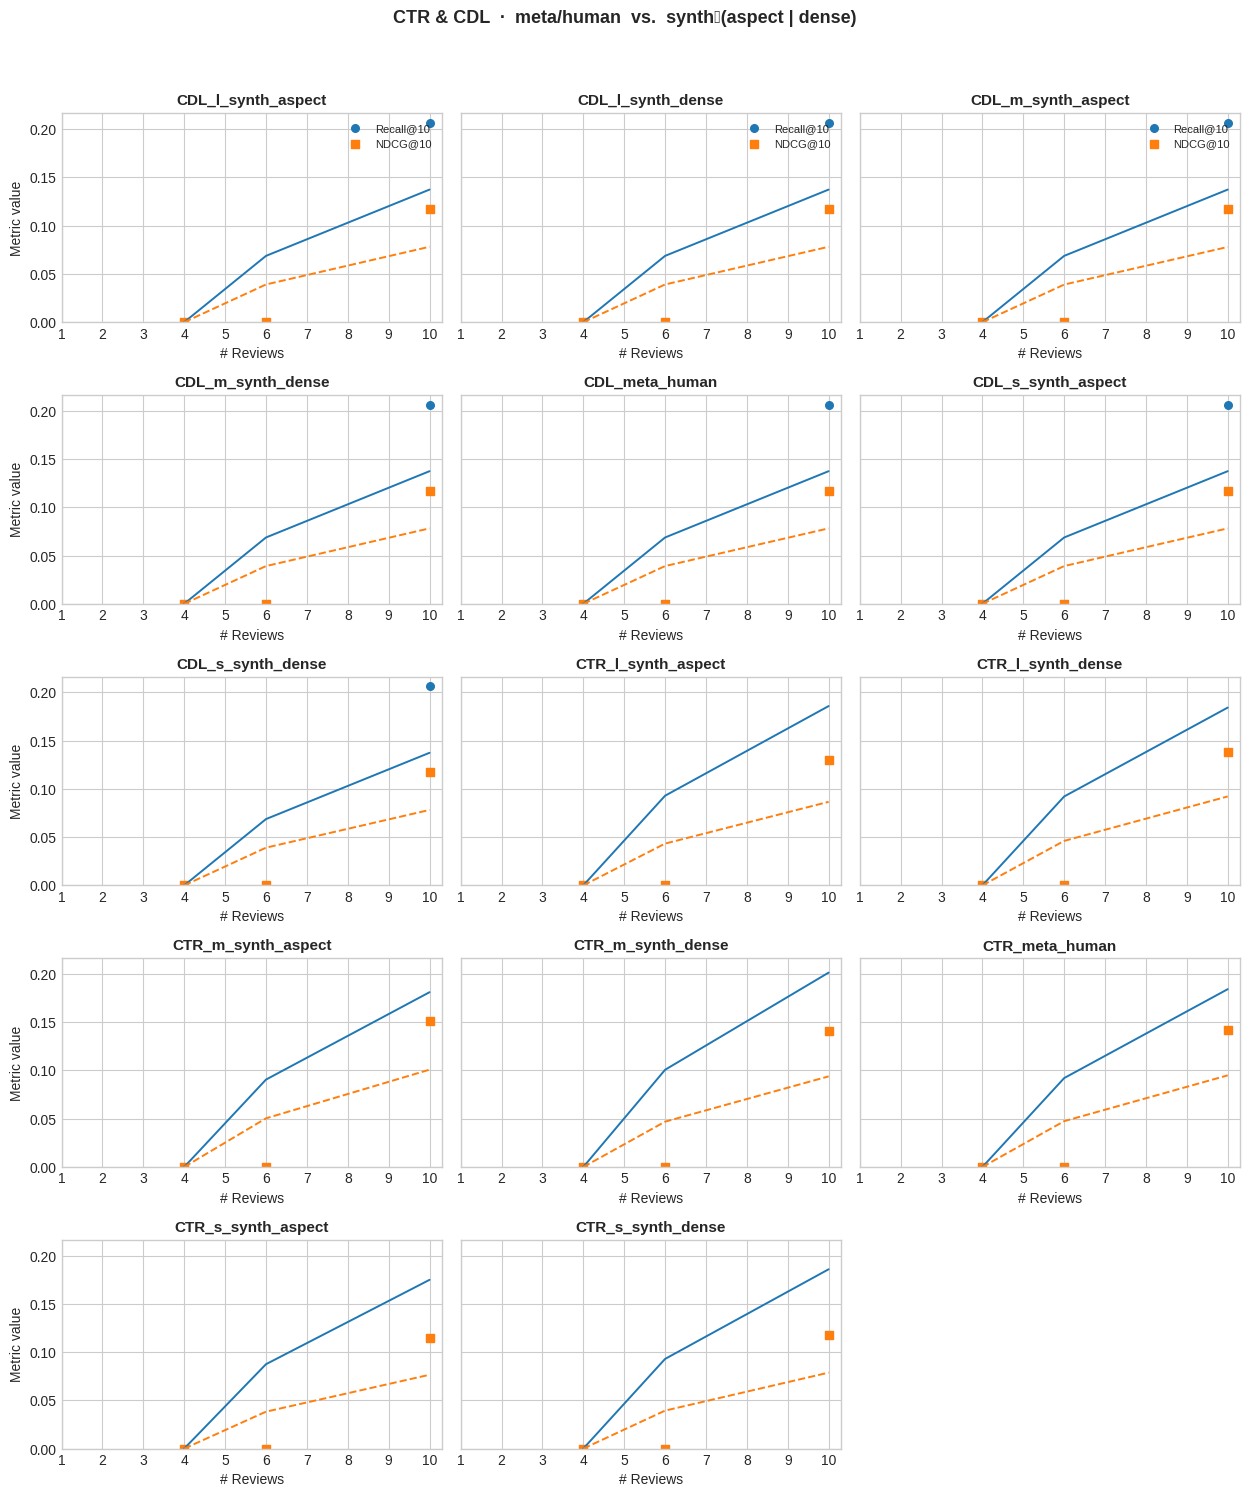

In [ ]:
##############################################################################
#  BLOCK 6 — CTR/CDL · meta_human + synth_(aspect|dense)   (discrete 1‑10)
##############################################################################
"""
Plots Recall@10 & NDCG@10 versus exact review count (1…10) for *every* CTR/CDL
model that is meta‑human or a synth‑aspect / synth‑dense variant.
"""
import numpy as np, pandas as pd, matplotlib.pyplot as plt, math, logging, re

# --------------------------- PARAMETERS ------------------------------------
MAX_N     = 10          # highest #reviews considered
K         = 10          # cut‑off for hit metrics
FAMILIES  = {"CTR", "CDL"}

# --------------------------- 0 · SANITY ------------------------------------
if "n_reviews" not in side_df.columns:
    logging.warning("⚠️  No ‘n_reviews’ column – skipping block")
else:
    sub_side = side_df[side_df.n_reviews.between(1, MAX_N)].copy()
    if sub_side.empty:
        raise RuntimeError("No items with 1…10 reviews in side data.")
    item2n = dict(zip(sub_side.itemId, sub_side.n_reviews))

    # ----------------------- 1 · METRIC COLLECTION -------------------------
    rows = []
    pattern_ok = re.compile(r"(meta_human$|synth_(?:aspect|dense)$)")
    for tag in final_models:
        fam, *rest = tag.split("_", 1)
        suf = rest[0] if rest else ""

        if fam not in FAMILIES or not pattern_ok.search(suf):
            continue                     # skip unwanted model

        rcol = f"rec_{tag}"
        if rcol not in recs.columns:
            continue

        hit_rc, hit_ndcg, denom = ({n: 0   for n in range(1, MAX_N+1)},
                                   {n: 0.0 for n in range(1, MAX_N+1)},
                                   {n: 0   for n in range(1, MAX_N+1)})

        for gt, rec in zip(recs["gt"], recs[rcol]):
            for it in gt:
                n = item2n.get(it);  denom[n] += int(n is not None)
            for rank, it in enumerate(rec[:K], 1):
                n = item2n.get(it)
                if n and it in gt:
                    hit_rc[n]   += 1
                    hit_ndcg[n] += 1 / math.log2(rank + 1)

        for n in range(1, MAX_N+1):
            if denom[n] == 0:               # no relevant items of that size
                continue
            rows.append({"model": tag, "n": n,
                         "Recall@10": hit_rc[n] / denom[n],
                         "NDCG@10":   hit_ndcg[n] / denom[n]})

    met_df = pd.DataFrame(rows)
    if met_df.empty:
        raise RuntimeError("No CTR/CDL models matched the filter!")

    # keep models in alphabetical order for readability
    models = sorted(met_df["model"].unique())
    met_df["model"] = pd.Categorical(met_df["model"], categories=models,
                                     ordered=True)

    # ----------------------- 2 · PLOTTING ----------------------------------
    plt.style.use("seaborn-v0_8-whitegrid")

    n_models = len(models)
    n_cols   = min(3, n_models)
    n_rows   = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4.2 * n_cols, 3.0 * n_rows),
                             squeeze=False, sharey=True)

    def _smooth(y):
        y_pad = np.pad(y, (1, 1), mode="edge")
        return (y_pad[:-2] + y_pad[1:-1] + y_pad[2:]) / 3

    for idx, model in enumerate(models):
        ax  = axes.flat[idx]
        sub = met_df[met_df.model == model].sort_values("n")

        ax.scatter(sub["n"], sub["Recall@10"], marker="o", s=30,
                   label="Recall@10")
        ax.scatter(sub["n"], sub["NDCG@10"],   marker="s", s=30,
                   label="NDCG@10")

        xs = sub["n"].values
        ax.plot(xs, _smooth(sub["Recall@10"].values), lw=1.4)
        ax.plot(xs, _smooth(sub["NDCG@10"].values),   lw=1.4, linestyle="--")

        ax.set_xticks(range(1, MAX_N + 1))
        ax.set_ylim(bottom=0)
        ax.set_xlabel("# Reviews")
        ax.set_title(model, fontsize=11, weight="bold")

        if idx % n_cols == 0:
            ax.set_ylabel("Metric value")
        if idx < n_cols:
            ax.legend(frameon=False, fontsize=8, loc="upper right")

    # Hide any leftover blank axes
    for ax in axes.flat[len(models):]:
        ax.axis("off")

    plt.suptitle("CTR & CDL  ·  meta/human  vs.  synth (aspect | dense)",
                 y=0.995, fontsize=13, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    plot_name = f"metric_vs_nreviews_filtered_{SLUG}.pdf"
    plt.savefig(plot_name, dpi=150, bbox_inches="tight")

    plt.show()


In [ ]:
##############################################################################
#  BLOCK 7 — Flexible Hybrid Ensembling  ✱ many combinations ✱   (UPDATED)
##############################################################################
"""This version
   • puts every column “rec_*” into the candidate pool (BPR, MF, CTR …),
   • builds ensembles for every *pair* of base recommenders,
   • evaluates *all* bases + ensembles on Recall / NDCG / MRR @ {5,10,50}.
"""
import itertools, collections, math, logging
import numpy as np, pandas as pd
from functools import partial
from typing import Dict, List, Callable

CUTS = [5, 10, 50]                       # ← already defined earlier

# ─────────────────────────────────────────────────────────────────────────────
# 0 · gather base recommenders (include unimodal CF ones)                     │
# ─────────────────────────────────────────────────────────────────────────────
BASE_MODEL_COLS = [c for c in recs.columns
                   if c.startswith("rec_") and not c.startswith("rec_ENS_")]
if not BASE_MODEL_COLS:
    raise RuntimeError("No base recommendation columns found!")

logging.info("🧱  Base recommenders: %d  → %s",
             len(BASE_MODEL_COLS), ", ".join(c[4:] for c in BASE_MODEL_COLS))

# Helper to make short‑ish printable model IDs (strip leading “rec_”)
def _clean(tag: str) -> str: return tag[4:]

# ─────────────────────────────────────────────────────────────────────────────
# 1 · fusion primitives (same as before)                                      │
# ─────────────────────────────────────────────────────────────────────────────
def _ranks(lst): return {it: r for r, it in enumerate(lst, 1)}

def borda(d):
    s = collections.Counter()
    for lst in d.values():
        for r, it in enumerate(lst, 1):
            s[it] += 1.0 / r
    return [it for it, _ in s.most_common(10)]

def wborda(d, weights):
    s = collections.Counter()
    for name, lst in d.items():
        w = weights.get(name, 1.)
        for r, it in enumerate(lst, 1):
            s[it] += w / r
    return [it for it, _ in s.most_common(10)]

def rrf(d, k=60):
    s = collections.Counter()
    for lst in d.values():
        for r, it in enumerate(lst, 1):
            s[it] += 1.0 / (k + r)
    return [it for it, _ in s.most_common(10)]

def mean_rank(d, weights=None):
    all_items = set(itertools.chain(*d.values()))
    rs = collections.Counter()
    for it in all_items:
        for name, lst in d.items():
            w = 1. if weights is None else weights.get(name, 1.)
            rs[it] += w * _ranks(lst).get(it, 1000)
    return [it for it, _ in rs.most_common()][:10]

# ─────────────────────────────────────────────────────────────────────────────
# 2 · define which pairs to ensemble                                          │
# ─────────────────────────────────────────────────────────────────────────────
# • All unordered pairs of base recommenders (⚠ can be large!)
#pair_iter = itertools.combinations(BASE_MODEL_COLS, 2)

# If you only want combos that include BPR, uncomment:
pair_iter = ((m1, m2) for m1, m2 in itertools.combinations(BASE_MODEL_COLS, 2)
                             if "rec_BPR" in (m1, m2))

# ─────────────────────────────────────────────────────────────────────────────
# 3 · generate all ensembles                                                  │
# ─────────────────────────────────────────────────────────────────────────────
WEIGHT_PAIRS = [(0.1, 0.9), (0.3, 0.7), (0.5, 0.5), (0.7, 0.3), (0.9, 0.1)]
RRF_KS       = [10, 30, 60, 90, 120]

new_cols = []          # we’ll collect the names to evaluate later

for m1, m2 in pair_iter:
    ens_prefix = f"ENS_{_clean(m1)}__{_clean(m2)}"      # double‑underscore keeps names unique

    # fusion functions specific to this pair (so weights can reference m1/m2)
    pair_fusions: Dict[str, Callable[[Dict[str, List[int]]], List[int]]] = {
        "borda": borda,
        "mean":  mean_rank,
    }
    for k in RRF_KS:
        pair_fusions[f"rrf_k{k}"] = partial(rrf, k=k)
    for a, b in WEIGHT_PAIRS:
        wt = {m1: a, m2: b}
        pair_fusions[f"wBorda_{a}_{b}"] = partial(wborda, weights=wt)
        pair_fusions[f"wMean_{a}_{b}"]  = partial(mean_rank, weights=wt)

    # build the new recommendation lists row‑wise
    ens_rows = []
    for tup in recs.itertuples(index=False):
        base_lists = {m1: getattr(tup, m1), m2: getattr(tup, m2)}
        entry = {"userId": tup.userId}
        for tag, fn in pair_fusions.items():
            col_name = f"rec_{ens_prefix}_{tag}"
            entry[col_name] = fn(base_lists)
        ens_rows.append(entry)

    df_add = pd.DataFrame(ens_rows)
    recs   = recs.merge(df_add, on="userId", how="left")
    new_cols.extend(df_add.columns.difference(["userId"]))

logging.info("🔧  Added %d new ensemble columns", len(new_cols))

# ─────────────────────────────────────────────────────────────────────────────
# 4 · evaluate every base + every ensemble                                    │
# ─────────────────────────────────────────────────────────────────────────────
models_to_eval = BASE_MODEL_COLS + new_cols

metric_rows = []
for tag in models_to_eval:
    preds = recs[tag].tolist()
    gts   = recs["gt"].tolist()

    arr_rc = np.zeros((len(recs), len(CUTS)))
    arr_nd = np.zeros_like(arr_rc)
    arr_mr = np.zeros_like(arr_rc)

    for i, (rec_list, gt_list) in enumerate(zip(preds, gts)):
        gt_set = set(gt_list)
        for j, k in enumerate(CUTS):
            topk = rec_list[:k]
            # Recall
            arr_rc[i, j] = len(set(topk) & gt_set) / len(gt_set) if gt_set else 0.
            # NDCG
            dcg  = sum(1 / math.log2(r + 2) for r, it in enumerate(topk) if it in gt_set)
            idcg = sum(1 / math.log2(r + 2) for r in range(min(len(gt_set), k)))
            arr_nd[i, j] = dcg / idcg if idcg else 0.
            # MRR
            arr_mr[i, j] = next((1 / (r + 1)
                                 for r, it in enumerate(topk) if it in gt_set), 0.)

    summary = {f"Recall@{CUTS[j]}": arr_rc[:, j].mean() for j in range(len(CUTS))}
    summary |= {f"NDCG@{CUTS[j]}":  arr_nd[:, j].mean() for j in range(len(CUTS))}
    summary |= {f"MRR@{CUTS[j]}":   arr_mr[:, j].mean() for j in range(len(CUTS))}
    metric_rows.append({"model": _clean(tag), **summary})

hyb_metrics = (pd.DataFrame(metric_rows)
               .sort_values(["Recall@10", "Recall@5"], ascending=False)
               .reset_index(drop=True))



print("══════ ALL BASE & ENSEMBLE METRICS ══════")
display(hyb_metrics.head(30))          # tweak or remove .head() to see everything

# Save the results as a CSV file for download
# ─── BLOCK 7 – right after hyb_metrics is created ─────────────────────
# replace the two lines
file_name = f"ensemble_metrics_full_{SLUG}.csv"
hyb_metrics.to_csv(file_name, index=False)

print(f"Saved → {file_name}")

logging.info(f"✅ Full ensemble metrics saved → {file_name}")


══════ ALL BASE & ENSEMBLE METRICS ══════


,model,Recall@5,Recall@10,Recall@50,NDCG@5,NDCG@10,NDCG@50,MRR@5,MRR@10,MRR@50
0,CTR_all_reviews_text,0.222013,0.326023,0.631997,0.145981,0.179606,0.248772,0.124394,0.138576,0.153175
1,ENS_BPR__CTR_all_reviews_text_wBorda_0.1_0.9,0.227026,0.322264,0.322264,0.148204,0.178929,0.178929,0.125731,0.138763,0.138763
2,ENS_BPR__CTR_all_reviews_text_rrf_k30,0.203843,0.321637,0.321637,0.126282,0.164988,0.164988,0.103091,0.119792,0.119792
3,ENS_BPR__CTR_m_synth_dense_rrf_k60,0.195489,0.314119,0.314119,0.123101,0.162507,0.162507,0.101880,0.119279,0.119279
4,ENS_BPR__CTR_all_reviews_text_rrf_k10,0.212615,0.313492,0.313492,0.129478,0.162723,0.162723,0.104553,0.119036,0.119036
5,ENS_BPR__CTR_all_reviews_text_rrf_k60,0.211362,0.312865,0.312865,0.128736,0.161725,0.161725,0.103968,0.118016,0.118016
6,ENS_BPR__CTR_all_reviews_text_wBorda_0.3_0.7,0.215748,0.312239,0.312239,0.140021,0.171214,0.171214,0.118546,0.131871,0.131871
7,ENS_BPR__CTR_m_synth_aspect_rrf_k30,0.211153,0.312239,0.312239,0.128243,0.161397,0.161397,0.103843,0.117829,0.117829
8,ENS_BPR__CTR_m_synth_dense_rrf_k30,0.197995,0.311612,0.311612,0.123849,0.161778,0.161778,0.102172,0.118839,0.118839
9,ENS_BPR__CTR_meta_only_rrf_k60,0.211362,0.311612,0.311612,0.123826,0.157059,0.157059,0.098079,0.112676,0.112676


Saved → ensemble_metrics_full_Magazine_Subscriptions.csv


In [ ]:
##############################################################################
#  BLOCK 8 — Convenience downloads (Colab helpers)          (FIXED VERSION)
##############################################################################
"""Gather every artefact produced in the run and trigger a browser-side
download when executed inside Google Colab.  Safe to run locally – the
`files` import fails gracefully and nothing happens.

Files collected (if they exist)
-------------------------------
* per-user recommendations      → ``reclist_df_<slug>.csv``
* aggregate metrics             → ``agg_metrics_<slug>.csv``
* ensemble / hybrid metrics     → ``ensemble_metrics_full_<slug>.csv``
* review-bucket metrics         → ``bucket_metrics_<slug>.csv``
* review-bucket visibility      → ``bucket_visibility_<slug>.csv``
* review-count plot             → ``metric_vs_nreviews_filtered_<slug>.pdf``
* configuration in JSON form    → ``config_used_<slug>.json``
"""
from __future__ import annotations

import json, pathlib, shutil, logging
from dataclasses import asdict

# ───── 0 · Detect Colab environment ────────────────────────────────────────
try:
    from google.colab import files      # noqa: F401
    _COLAB = True
except Exception:                        # pragma: no cover
    _COLAB = False

# ───── 1 · Resolve the unique slug used across the run ─────────────────────
# The main script should define `SLUG = fn_prefix` right after Block 5.
if "SLUG" not in globals():
    logging.warning("⚠️  Global SLUG not found – falling back to simple slug.")
    SLUG = DS_SLUG.replace("/", "_")          # type: ignore

# ───── 2 · Write configuration snapshot ────────────────────────────────────
cfg_name = f"config_used_{SLUG}.json"
cfg_path = pathlib.Path(cfg_name)
if not cfg_path.exists():
    cfg_dict = asdict(CFG())
    json.dump(cfg_dict, cfg_path.open("w"), indent=2)

# ───── 3 · List all candidate artefacts ------------------------------------
files_to_download = [
    f"reclist_df_{SLUG}.csv",
    f"agg_metrics_{SLUG}.csv",
    f"ensemble_metrics_full_{SLUG}.csv",
    f"bucket_visibility_{SLUG}.csv",
    f"bucket_metrics_{SLUG}.csv",
    f"metric_vs_nreviews_filtered_{SLUG}.pdf",
    cfg_name,
]

# Keep only those that actually exist on disk
files_to_download = [f for f in files_to_download if pathlib.Path(f).exists()]
logging.info("📄 Files prepared for download: %s",
             ", ".join(files_to_download) if files_to_download else "none")

# ───── 4 · Trigger downloads in Google Colab, or just log when local ───────
if _COLAB:
    import time
    for fp in files_to_download:
        try:
            files.download(fp)
            time.sleep(0.25)            # small delay to avoid throttling
        except Exception as e:
            logging.warning("Could not download %s: %s", fp, e)
else:
    logging.info("📂 Not in Colab – automatic downloads skipped; "
                 "files are available in the current working directory.")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>